# Example: Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  MelbourneAirport     18.0     26.9      21.4          7.0       8.9   
1          Adelaide     17.2     23.4       0.0          NaN       NaN   
2            Cairns     18.6     24.6       7.4          3.0       6.1   
3          Portland     13.6     16.8       4.2          1.2       0.0   
4           Walpole     16.4     19.9       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
0         SSE           41.0          W        SSE  ...         95.0   
1           S           41.0          S        WSW  ...         59.0   
2         SSE           54.0        SSE         SE  ...         78.0   
3         ESE           39.0        ESE        ESE  ...         76.0   
4          SE           44.0         SE         SE  ...         78.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         54.0       1019.5       1017.0       8.0       5.0     18.5   
1         36.0       1015.7       1015.7       NaN       NaN     17.7   
2         57.0       1018.7       1016.6       3.0       3.0     20.8   
3         74.0       1021.4       1020.5       7.0       8.0     15.6   
4         70.0       1019.4       1018.9       NaN       NaN     17.4   

   Temp3pm  RainToday  RainTomorrow  
0     26.0        Yes             0  
1     21.9         No             0  
2     24.1        Yes             0  
3     16.0        Yes             1  
4     18.1         No             0  

[5 rows x 22 columns]

## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, infrequent_to_value=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9846
Test evaluation --> auc: 0.8783
Time elapsed: 1.012s
-------------------------------------------------
Time: 1.012s


Final results ==================== >>
Total time: 1.017s
-------------------------------------
LightGBM --> auc: 0.8783


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

Successfully created new branch: dfs.


In [6]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Generating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Location                      0
MinTemp                       0
MaxTemp                       0
Rainfall                      0
Evaporation                   0
                             ..
WindDir3pm + WindGustSpeed    0
WindDir9am + WindGustDir      0
WindDir9am - WindGustDir      0
WindGustDir + WindSpeed3pm    0
RainTomorrow                  0
Length: 74, dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature MinTemp was removed due to collinearity with another feature.
 --> Feature Location + MinTemp was removed due to collinearity with another feature.
 --> Feature MinTemp + RainToday_No was removed due to collinearity with another feature.
 --> Feature MinTemp - WindDir3pm was removed due to collinearity with another feature.
 --> Feature MinTemp - WindDir9am was removed due to collinearity with another feature.
 --> Feature MaxTemp was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature Location + MaxTemp was removed due to collinearity with another feature.
 --> Feature Location + Temp3pm was removed due to collinearity with another feature.
 --> Feature MaxTemp - RainToday_Yes was removed due to collinearity with another feature.
 --> Feature MaxTemp - WindGustDir was removed due to collinearity with another feature.
 --> Featur

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear_

drop  \
0                              MinTemp   
1                   Location + MinTemp   
2               MinTemp + RainToday_No   
3                 MinTemp - WindDir3pm   
4                 MinTemp - WindDir9am   
5                              MaxTemp   
6                              Temp3pm   
7                   Location + MaxTemp   
8                   Location + Temp3pm   
9              MaxTemp - RainToday_Yes   
10               MaxTemp - WindGustDir   
11                         Evaporation   
12            Evaporation + WindDir3pm   
13                            Sunshine   
14                         WindGustDir   
15                       WindGustSpeed   
16                        WindSpeed3pm   
17                         Humidity9am   
18                         Humidity3pm   
19              Humidity3pm + Sunshine   
20           Humidity3pm + WindGustDir   
21              Humidity3pm - Location   
22          Humidity3pm - RainToday_No   
23  Humidity3pm - RainToday_infrequent   
24     Cloud9am - RainToday_infrequent   
25                             Temp9am   
26          RainToday_Yes - WindDir3pm   
27                   MinTemp + Temp3pm   

                                         corr_feature  \
0   Location + MinTemp, MinTemp + RainToday_No, Mi...   
1   MinTemp, MinTemp + RainToday_No, MinTemp + Win...   
2   MinTemp, Location + MinTemp, MinTemp + WindGus...   
3   MinTemp, Location + MinTemp, MinTemp + RainTod...   
4   MinTemp, Location + MinTemp, MinTemp + RainTod...   
5   Temp3pm, Location + MaxTemp, Location + Temp3p...   
6   MaxTemp, Location + MaxTemp, Location + Temp3p...   
7   MaxTemp, Temp3pm, Location + Temp3pm, MaxTemp ...   
8   MaxTemp, Temp3pm, Location + MaxTemp, MaxTemp ...   
9   MaxTemp, Temp3pm, Location + MaxTemp, Location...   
10  MaxTemp, Temp3pm, Location + MaxTemp, Location...   
11  Evaporation + RainToday_Yes, Evaporation + Win...   
12           Evaporation, Evaporation + RainToday_Yes   
13                              Sunshine + WindDir3pm   
14                             Location + WindGustDir   
15                         WindDir3pm + WindGustSpeed   
16                         WindGustDir + WindSpeed3pm   
17                          Humidity9am + WindGustDir   
18  Evaporation + Humidity3pm, Humidity3pm + Sunsh...   
19  Humidity3pm, Evaporation + Humidity3pm, Humidi...   
20  Humidity3pm, Evaporation + Humidity3pm, Humidi...   
21  Humidity3pm, Evaporation + Humidity3pm, Humidi...   
22  Humidity3pm, Evaporation + Humidity3pm, Humidi...   
23  Humidity3pm, Evaporation + Humidity3pm, Humidi...   
24                                           Cloud9am   
25                              Temp9am + WindGustDir   
26                                      RainToday_Yes   
27                                  MaxTemp + MinTemp   

                                        corr_value  
0                       1.0, 0.9979, 1.0, 1.0, 1.0  
1                       1.0, 0.9979, 1.0, 1.0, 1.0  
2           0.9979, 0.9979, 0.9978, 0.9979, 0.9979  
3                    1.0, 1.0, 0.9979, 0.9999, 1.0  
4                    1.0, 1.0, 0.9979, 0.9999, 1.0  
5         0.9834, 1.0, 0.9834, 0.9999, 0.9985, 1.0  
6      0.9834, 0.9834, 1.0, 0.9833, 0.9825, 0.9835  
7         1.0, 0.9834, 0.9834, 0.9999, 0.9985, 1.0  
8      0.9834, 1.0, 0.9834, 0.9833, 0.9825, 0.9835  
9   0.9985, 0.9825, 0.9985, 0.9825, 0.9984, 0.9984  
10        1.0, 0.9835, 1.0, 0.9835, 0.9999, 0.9984  
11                                  0.9936, 0.9999  
12                                  0.9999, 0.9935  
13                                          0.9999  
14                                             1.0  
15                                             1.0  
16                                             1.0  
17                                             1.0  
18           0.9857, 0.9911, 1.0, 1.0, 0.9998, 1.0  
19  0.9911, 0.9804, 0.9911, 0.9911, 0.9907, 0.9911  
20           1.0, 0.9857, 0.9911, 1.0, 0.9998, 1

In [11]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs", errors="raise")


Training ========================= >>
Models: LGB_dfs
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.991
Test evaluation --> auc: 0.8768
Time elapsed: 1.673s
-------------------------------------------------
Time: 1.673s


Final results ==================== >>
Total time: 1.678s
-------------------------------------
LightGBM --> auc: 0.8768


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_main"

Successfully created new branch: gfg.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.02         0.139961        3         0.490021              N/A     23.20s
   1     3.18         0.357605        7          0.49915              N/A     22.79s
   2     3.82         0.425184       10         0.517679              N/A     22.07s
   3     4.54           0.4404        9         0.527987              N/A     20.03s
   4     6.87         0.445283       11         0.538222              N/A     18.79s
   5     9.75         0.455204       15         0.543529              N/A     17.89s
   6    11.53         0.456228       19         0.546248              N/A     16.75s
   7    11.94         0.456611       21         0.547784              N/A     17.84s
   8    12.74         0.463229       23        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features_

name                                        description   fitness
0   x23  add(add(sub(Cloud3pm, mul(RainToday_No, abs(Wi...  0.542362
1   x24  add(add(sub(Cloud3pm, mul(RainToday_No, abs(Wi...  0.542049
2   x25  add(add(sub(Cloud3pm, mul(RainToday_No, abs(Wi...  0.540022
3   x26  add(add(sub(Cloud3pm, mul(RainToday_No, Sunshi...  0.534542
4   x27  add(sub(sub(sub(Humidity3pm, Pressure3pm), mul...  0.533542
5   x28  add(add(sub(sub(Cloud3pm, mul(RainToday_No, Su...  0.533542
6   x29  add(sub(sub(sub(Humidity3pm, Pressure3pm), abs...  0.533542
7   x30  add(sub(sub(Humidity3pm, Pressure3pm), mul(Rai...  0.532984
8   x31  sub(Sunshine, add(add(sub(Cloud3pm, abs(WindSp...  0.532205
9   x32  sub(Sunshine, add(add(sub(Cloud3pm, abs(WindSp...  0.532200
10  x33  add(add(sub(Cloud3pm, abs(WindSpeed3pm)), Wind...  0.532200
11  x34  add(sub(sub(sub(Humidity3pm, Sunshine), Pressu...  0.532200
12  x35  add(sub(sub(sub(Humidity3pm, Pressure3pm), Sun...  0.532200
13  x36  sub(Sunshine, add(add(sub(Cloud3pm, abs(WindSp...  0.532200
14  x37  add(add(sub(Cloud3pm, abs(WindSpeed3pm)), Wind...  0.532200
15  x38  sub(add(add(sub(Humidity3pm, Pressure3pm), Win...  0.532200
16  x39  add(sub(sub(sub(sub(Humidity3pm, Pressure3pm),...  0.531546
17  x40  add(add(sub(Cloud3pm, abs(WindSpeed3pm)), Wind...  0.531546
18  x41  sub(Sunshine, add(add(sub(Cloud3pm, abs(abs(Wi...  0.531200
19  x42  add(sub(sub(sub(Humidity3pm, Pressure3pm), Sun...  0.531067

In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9884
Test evaluation --> auc: 0.8791
Time elapsed: 1.487s
-------------------------------------------------
Time: 1.487s


Final results ==================== >>
Total time: 1.493s
-------------------------------------
LightGBM --> auc: 0.8791


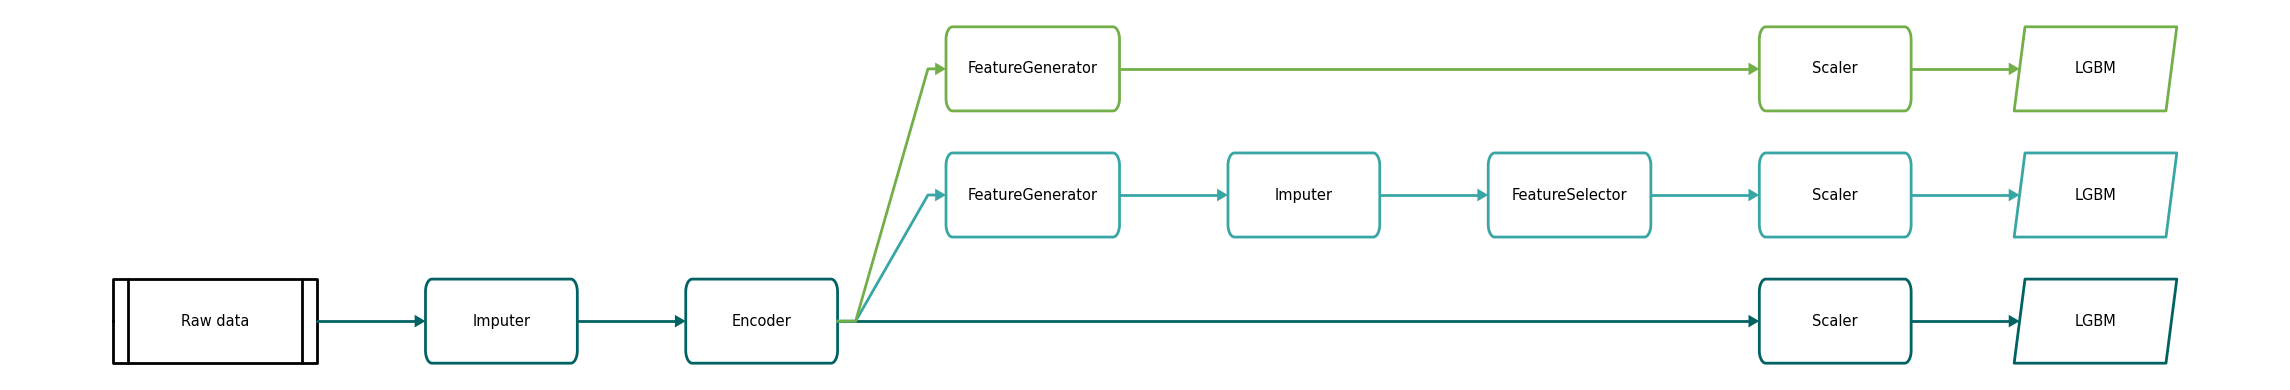

In [17]:
# Visualize the whole pipeline
atom.plot_pipeline()

## Analyze the results

In [18]:
# Use atom's plots to compare the three models
atom.plot_roc(rows="test+train")

In [19]:
# To compare other plots it might be useful to use a canvas
with atom.canvas(1, 2, figsize=(1800, 800)):
    atom.lgb_dfs.plot_roc(rows="test+train")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")

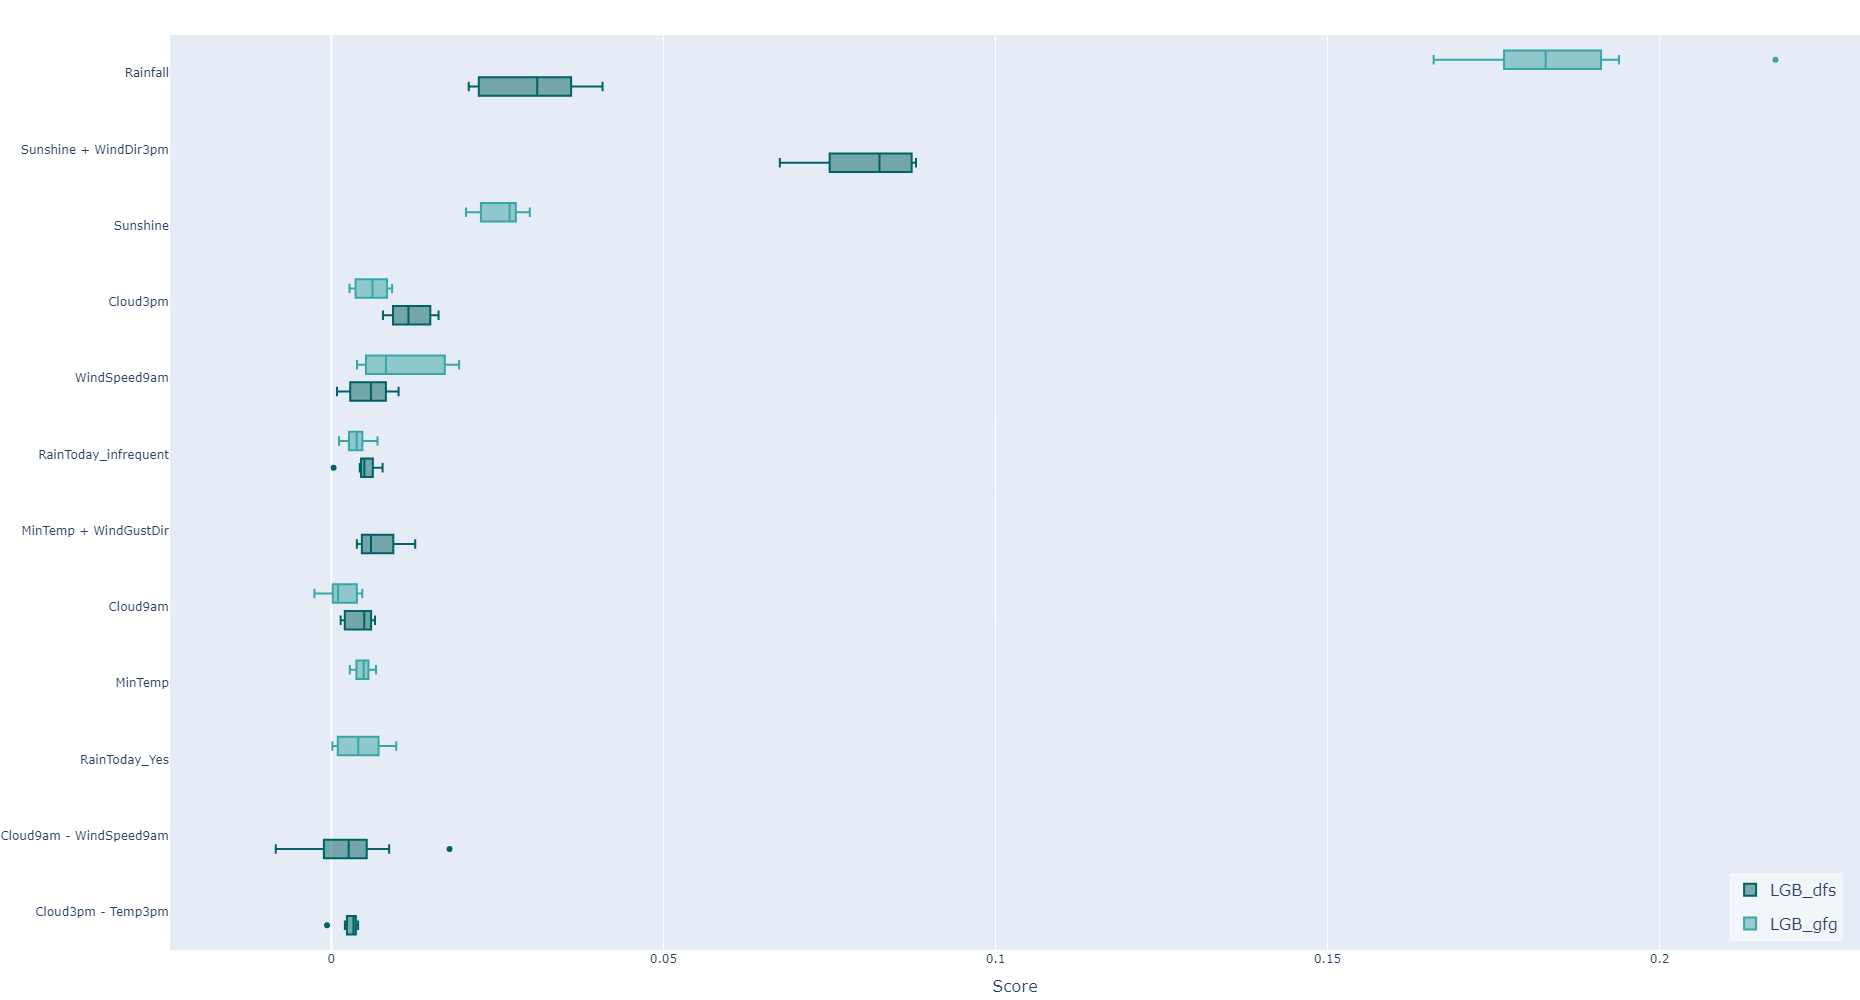

In [20]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=12)

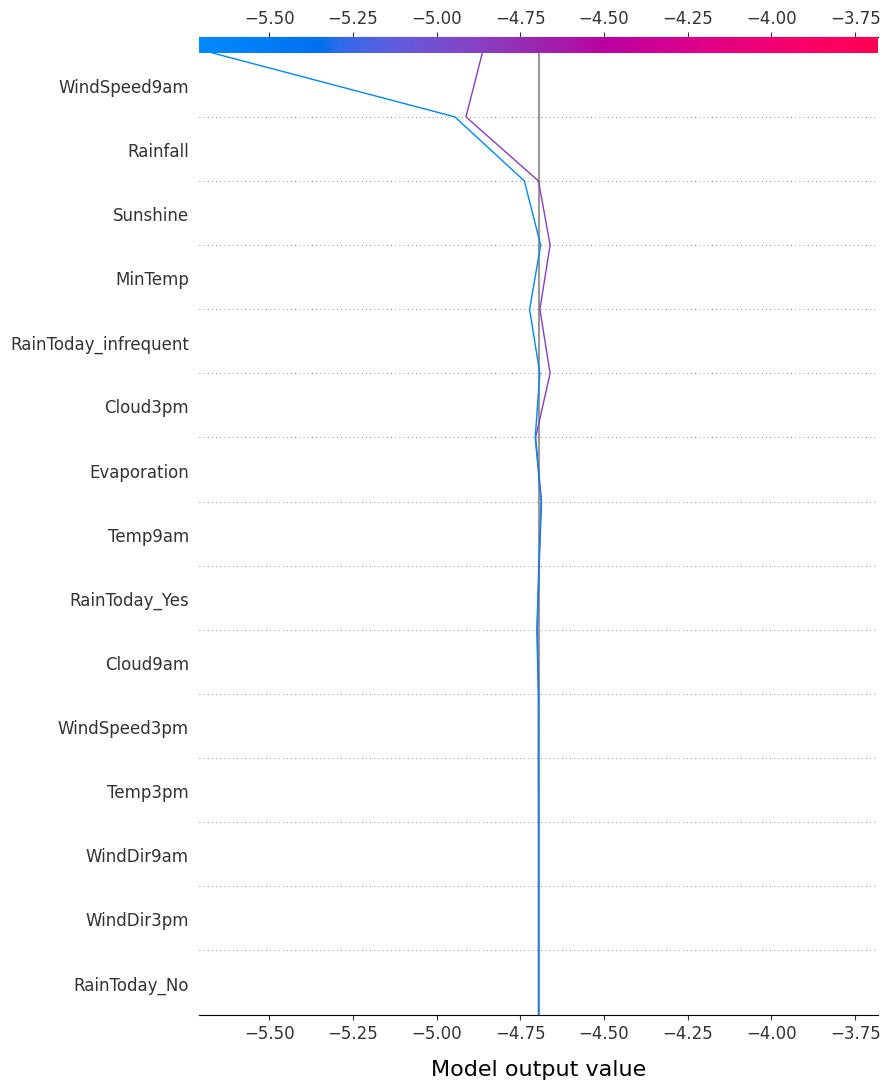

In [21]:
atom.LGB_gfg.plot_shap_decision(rows=(0, 10), show=15)